# MLE Portfolio Project - Customer Churn 

This project is to finish the course `Machine Learning/AI Engineer Career Path` on [CodeCademy](https://www.codecademy.com/) and to showcase what I have learned by implementing some concepts and creating clean and reproducible code.

Dataset: 
I took the data from [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download) and it is a dataset showing `Telco Customer Churn`. In the following project I will create machine learning pipelines to make out which models perform best and which features are most predictive of a customer churning.

This type of analysis could be of great help to businesses, as it attacks the problem of trend detection and future readiness.

In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score,classification_report
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import time
from imblearn.over_sampling import SMOTE


Let's load and inspect the data!

In [366]:
churn_df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
pd.set_option('display.max_columns', None)
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


I see that I won't need the customerID column and I can convert the columns with Yes/No to contain 1/0 valueas.

In [367]:
churn_df.drop('customerID', axis=1, inplace=True)
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [368]:
#value counts for each column in one dictionary
value_counts = {}
for column in churn_df.columns:
    if churn_df[column].dtype == 'object' and column != 'customerID':
        value_counts[column] = churn_df[column].value_counts()
        print(value_counts[column])
        print('\n')

Male      3555
Female    3488
Name: gender, dtype: int64


No     3641
Yes    3402
Name: Partner, dtype: int64


No     4933
Yes    2110
Name: Dependents, dtype: int64


Yes    6361
No      682
Name: PhoneService, dtype: int64


No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64


Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64


No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64


No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64


No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64


No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64


No                     2810
Yes                    2707
No internet service    15

I see that TotalCharges has to be changed to numeric as it is a type "object". I will also set "No internet service" to "No" in multiple columns for easier handling later on.

Let's actually do these changes!

In [369]:
no_internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
no_phone_services = ['MultipleLines']

for column in no_internet_services:
    churn_df[column] = churn_df[column].replace({'No internet service': 'No'})

churn_df['MultipleLines'] = churn_df['MultipleLines'].replace({'No phone service': 'No'})

yes_no_columns = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
for column in yes_no_columns:
    churn_df[column] = churn_df[column].map({'Yes': 1, 'No': 0})
#map male to 0 female to 1
churn_df['gender'] = churn_df['gender'].map({"Male":0, "Female":1})

churn_df["TotalCharges"] = pd.to_numeric(churn_df["TotalCharges"], errors='coerce')
churn_df['TotalCharges'] = churn_df['TotalCharges'].fillna(churn_df['TotalCharges'].mean())



Distribution of TotalCharges:

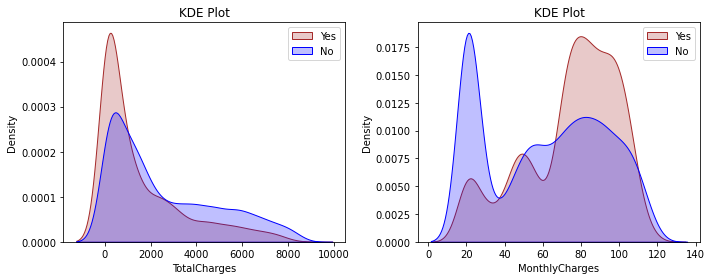

In [377]:
fig , ax = plt.subplots(1,2,figsize=(10,4))
sns.kdeplot(churn_df["TotalCharges"][churn_df["Churn"] == 1],fill=True,ax=ax[0], color='brown')
sns.kdeplot(churn_df["TotalCharges"][churn_df["Churn"] == 0],fill=True,ax=ax[0], color='blue')
ax[0].legend(["Yes","No"])
ax[0].set_title("KDE Plot");

sns.kdeplot(churn_df["MonthlyCharges"][churn_df["Churn"] == 1],fill=True,ax=ax[1], color='brown')
sns.kdeplot(churn_df["MonthlyCharges"][churn_df["Churn"] == 0],fill=True,ax=ax[1], color='blue')
ax[1].legend(["Yes","No"])
ax[1].set_title("KDE Plot")
fig.tight_layout(h_pad=2)

For the remaining object type columns I will implement One Hot Encoding.

In [346]:
for column in churn_df.columns:
    if churn_df[column].dtype == 'object' and column != 'customerID':
        value_counts[column] = churn_df[column].value_counts()
        print(value_counts[column])
        print('\n')

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64


Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64


Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64




In [347]:
churn_df = pd.get_dummies(churn_df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)

In [348]:
churn_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,0,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,0,0,1,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,0,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,0,0,1,0,0,0,0
4,1,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,1,0,0,0,0,1,0


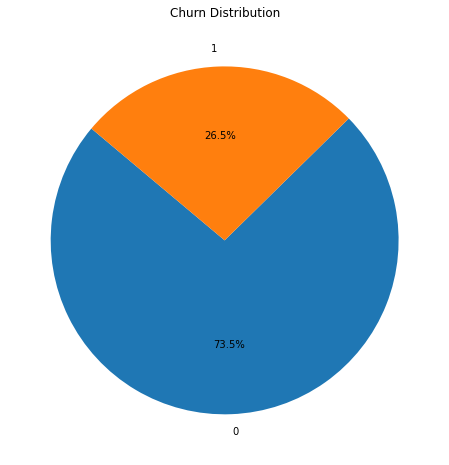

In [349]:
churn_counts = churn_df["Churn"].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Churn Distribution')
plt.show()

The sample is imbalanced and I will handle that with SMOTE, but first I will split the data into training and testing.

Nice!

In [350]:
X = churn_df.drop(['Churn'], axis=1)
y = churn_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

print(y_train.value_counts())
X_train.select_dtypes(include=['object']).columns

0    4148
1    1486
Name: Churn, dtype: int64


Index([], dtype='object')

In [351]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

print(y_train.value_counts())

1    4148
0    4148
Name: Churn, dtype: int64


After standardizing the data, I am able to implement the models that I will be using for this project and tune the hyperparameters.

First I will check the accuracy of the pipeline for logistic regression without tuning.

In [352]:
scaler = StandardScaler()
numeric_cols = ["tenure","MonthlyCharges","TotalCharges"]
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [353]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
pipeline_test_score = lr.score(X_test, y_test)
pipeline_train_score = lr.score(X_train, y_train)
print("The pipeline train score is: ", pipeline_train_score)
print("The pipeline test score is: ", pipeline_test_score)
print("The model is: ", lr.get_params())
print("The f1 score is: ", f1_score(y_test, lr.predict(X_test)))

The pipeline train score is:  0.828953712632594
The pipeline test score is:  0.7615330021291696
The model is:  {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
The f1 score is:  0.5902439024390245


Visualizing feature importance.

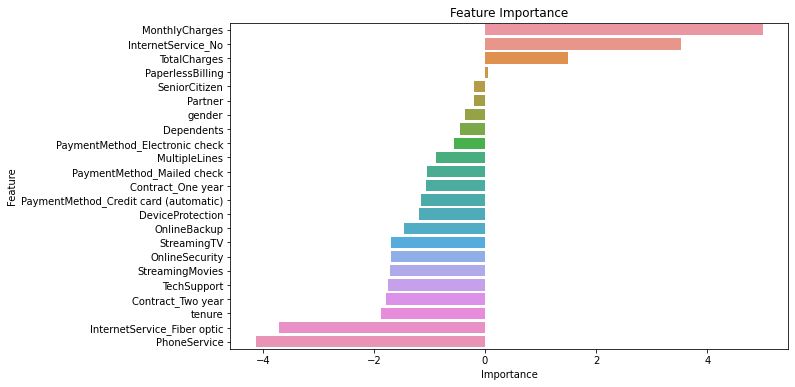

In [354]:
feature_importances = lr.coef_[0]

# Assuming you have a list of original feature names
feature_names = X.columns

# Create a DataFrame of feature importances
importances_df = pd.DataFrame(data={
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importance')
plt.show()


### Initial thoughts

Right off the bat I can see that high monthly charges and no internet service lead to a higher probability of a customer churning. On the other hand, if a customer is using multiple services (such as internet service fiber optic, phoneservice, streaming, online security) and has been a customer for a longer time, they are more likely to stay.

In [355]:
def parameter_finder (model, parameters):

    start = time.time()

    grid = GridSearchCV(model,
                        param_grid = parameters,
                        cv = 5,
                        scoring = 'f1',
                        n_jobs = 1)
    grid_fit = grid.fit(X_train, y_train)
    best = grid_fit.best_estimator_
    y_pred = best.predict(X_test)

    train_score =best.score(X_train, y_train)
    test_score = best.score(X_test, y_test)
    F1_score = f1_score(y_test, y_pred).round(2)
    results = classification_report(y_test, y_pred)
    model_name = str(model).split('(')[0]

    end = time.time()
    takes_time = np.round(end - start,2)

    print(f"The best parameters for {model_name} model is: {grid_fit.best_params_}")
    print("--" * 10)
    print(f"(R2 score) in the training set is {train_score:0.2%} for {model_name} model.")
    print(f"(R2 score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"F1 score is {F1_score:,} for {model_name} model.")
    print("--" * 10)
    print(f"Runtime of the program is: {end - start:0.2f}")


    return best,train_score, test_score, F1_score, y_pred, takes_time, results

In [356]:
def confusion(model,pred):
    cm = confusion_matrix(y_test, pred, labels=[0,1])
    dis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    dis.plot()
    plt.title(str(model).split("(")[0])

Now let the tuning commence!

In [357]:
lr_gs = LogisticRegression(max_iter = 1000)
logistic_regression_search = [
{
'penalty': ['l2', 'l1'],
'C': [0.001, 0.01, 0.1, 1, 10, 100],
'solver': ['liblinear']
}
]
lr_model, train_lr, test_lr, f1_lr, pred_lr, time_lr, lr_results = parameter_finder(lr_gs, logistic_regression_search)
print(lr_results)

The best parameters for LogisticRegression model is: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
--------------------
(R2 score) in the training set is 82.55% for LogisticRegression model.
(R2 score) in the testing set is 75.59% for LogisticRegression model.
F1 score is 0.59 for LogisticRegression model.
--------------------
Runtime of the program is: 6.04
              precision    recall  f1-score   support

           0       0.86      0.79      0.83      1026
           1       0.54      0.66      0.59       383

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.77      0.76      0.76      1409



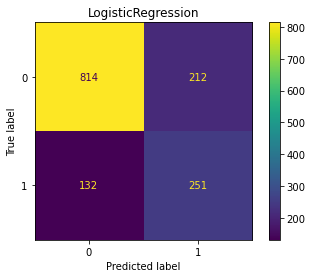

In [358]:
confusion(lr_gs,pred_lr)

In [359]:
rf_gs =RandomForestClassifier()
rf_search_space=[{
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 12],
},]
rf_model, train_rf, test_rf, f1_rf, pred_rf, time_rf, rf_results = parameter_finder(rf_gs, rf_search_space)
print(rf_results)

The best parameters for RandomForestClassifier model is: {'max_depth': 12, 'n_estimators': 200}
--------------------
(R2 score) in the training set is 93.31% for RandomForestClassifier model.
(R2 score) in the testing set is 76.51% for RandomForestClassifier model.
F1 score is 0.6 for RandomForestClassifier model.
--------------------
Runtime of the program is: 22.03
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1026
           1       0.56      0.65      0.60       383

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.77      1409



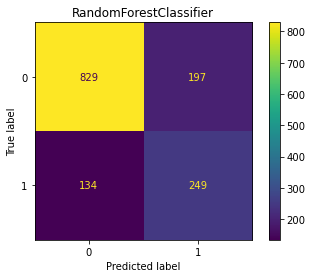

In [360]:
confusion(rf_gs,pred_rf)

In [361]:
knn_gs = KNeighborsClassifier()
knn_search_space=[{
    'n_neighbors': [3, 5, 7, 9,11,13],
    'weights': ['uniform', 'distance'],
    "p": [1,2]
},]
knn_model, train_knn, test_knn, f1_knn, pred_knn, time_knn, knn_results = parameter_finder(knn_gs, knn_search_space)
print(knn_results)

The best parameters for KNeighborsClassifier model is: {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
--------------------
(R2 score) in the training set is 84.09% for KNeighborsClassifier model.
(R2 score) in the testing set is 71.89% for KNeighborsClassifier model.
F1 score is 0.58 for KNeighborsClassifier model.
--------------------
Runtime of the program is: 21.69
              precision    recall  f1-score   support

           0       0.88      0.72      0.79      1026
           1       0.49      0.73      0.58       383

    accuracy                           0.72      1409
   macro avg       0.68      0.72      0.69      1409
weighted avg       0.77      0.72      0.73      1409



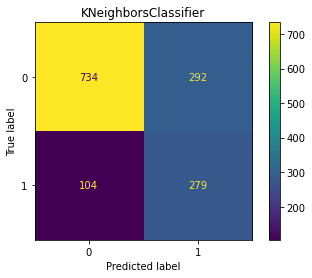

In [362]:
confusion(knn_gs,pred_knn)

In [363]:
result = {
    "Train Score":[train_lr,train_knn,train_rf],
    "test Score":[test_lr,test_knn,test_rf],
    "F1 Score":[f1_lr,f1_knn,f1_rf]
}

index = np.array(["Logistic Reg","KNeighbors",
                  "Random Forest "])

res_df = pd.DataFrame(data=result,index=index)
res_df

,Train Score,test Score,F1 Score
Logistic Reg,0.825458,0.755855,0.59
KNeighbors,0.840887,0.718950,0.58
Random Forest,0.933100,0.765082,0.60


The best performing model from the onces I looked at is the Random Forest Classifier.

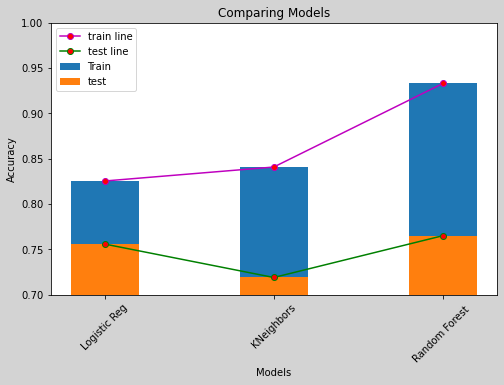

In [364]:
ig , ax = plt.subplots(figsize=(8,5),facecolor="lightgray")
x = np.arange(3)
ax.plot(x,res_df["Train Score"],marker="o",mfc="red",color="m",label="train line")
ax.bar(x,res_df["Train Score"],label="Train",width=0.4)
ax.plot(x,res_df["test Score"],marker="o",mfc="red",color="green",label="test line")
ax.bar(x,res_df["test Score"],label="test",width=0.4)
ax.set(xticks=x,ylim=[0.7,1],xlabel="Models",ylabel="Accuracy",
      title="Comparing Models")
ax.set_xticklabels(index,rotation=45)
ax.legend()

## Result

As a conclusion, I found that the company has to be mindful about the monthly charge, but the total charge doesn't seem to affect churn that much. Having a tighter relationship with customers makes them stay longer, so selling them on phone service, fiber optic internet service and two year contracts is key for a higher Lifetime Value. 

My best model has a 76% test score, meaning that it can predict whether a customer will churn this month with a 76% accuracy. 

For further analysis, I could include customer reviews and include the sentiment of them in the prediction. To improve the churn figure, continual tracking and reporting of progress is needed while I am optimizing the model and analyzing the new data. 